# Monthly Active Users Forecast
One of the main concerns marketing, growth and business teams have is to know beforehand hoy many active users they would achieve by end-of-month. This information is very useful for them to take actions in case they realize they are not going to achieve their monthly targets.

The datasets cannot be shared due to confidetiality of the company, but I can tell you they belong to a fintech company. The forecast is divided in 4 stages, each one aiming at forecasting a specific segment of users. This decision was taken after we saw that these segments behave very different from each other.

For every model Facebook's library prophet was used because of it's simplicity of use and it's ability to add extra effects such as holidays or special dates.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from datetime import timedelta
from prophet.make_holidays import make_holidays_df
from prophet.utilities import regressor_coefficients

/Users/fernandoemirgarade/opt/anaconda3/envs/ibk_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## Get Data

As it can be seen in the next cells, the datasets consists of a user_id and a date a user was active. 
For this company if a user made just 1 transaction in a given month, that meant this user was active that month. So, we just need to keep record of each user first transaction in each month.
As explained above, there are 4 different segments of users
- FTUs: First time users - New users. For these users we want to know the date of their first use of the product (in this case their first successful transaction).
- RUs M1: Returning users first month - Active users on the month that follows their FTU month. For these users we want to know the date of their first use on that M1 month.
- RUs ret: Returning users retained - Active users on the month (Mi where i>=2), that follows a previous active month that is not their FTU month. For these users we want to know the date of their first use on that Mi month.
- ZRs: Active users on the month (Mi where i>=2), that follows a previous non-active month. For these users we want to know the date of their first use on that Mi month.

## Data FTUs

In [2]:
#db_fecha_ftu = pd.read_sql(query_fecha_ftu, con=conn)
db_fecha_ftu = pd.read_csv('query_ftus.csv')

In [6]:
db_fecha_ftu.head()

,user_id,fecha_1ra_transacion_completed
0,dae29bf4-5802-45a5-8e33-f3cbd7448b4b,2021-09-09
1,f2716fc3-6da4-4452-8315-7f58f5680ee6,2021-09-07
2,774169ec-8236-4db2-8940-cb20b21e08aa,2021-09-22
3,e60d5853-4669-4103-9e24-016806e6001e,2021-03-27
4,7d41bf27-b904-408c-b554-fd73e0ba225c,2021-09-11


## Data RUs M1

In [3]:
#db_fecha_M1 = pd.read_sql(query_rus_M1, con=conn)
db_fecha_M1 = pd.read_csv('query_rus_m1.csv')

In [7]:
db_fecha_M1.head()

,user_id,first_returning_day_M1
0,fef3f529-e9a2-4358-becf-2083fdb9e275,2021-11-01
1,4d5e3540-b411-4db4-b2cc-517769516857,2021-11-09
2,174d0d68-06d0-4c39-a310-08acd1a1ea85,2021-11-01
3,7941f19a-290c-4f60-bd5a-d91771005910,2021-11-10
4,456daf61-6da8-44a6-9553-ba738341a3bb,2021-11-01


## Data RUs ret

In [4]:
#db_fecha_rusret = pd.read_sql(query_rus_ret, con=conn)
db_fecha_rusret = pd.read_csv('query_rus_ret.csv')

In [8]:
db_fecha_rusret.head()

,user_id,mes,first_returning_day_M2
0,ae5ceeed-af09-472f-8c15-db9cf3a9205d,2021-10-01,2021-10-04
1,179a405d-64e0-4af5-83b0-7385553b714d,2021-12-01,2021-12-01
2,aaf50cc1-070d-4fb6-beae-80ec3d8f8a5e,2021-10-01,2021-10-04
3,01c28045-e766-4bc8-84ba-4131ac504cba,2021-10-01,2021-10-04
4,45dda3ec-916c-4d2c-8e8f-50ce63df0f0c,2021-10-01,2021-10-04


## Data ZRs

In [5]:
#db_fecha_zrs = pd.read_sql(query_zrs, con=conn)
db_fecha_zrs = pd.read_csv('query_zrs.csv')

In [9]:
db_fecha_zrs.head()

,user_id,mes,first_returning_day_M2
0,61766745-18ec-4b32-aeaf-f44cd4d037b5,2021-09-01,2021-09-24
1,6203e423-8f33-4a4a-9cda-8af2ebe8bcdb,2021-09-01,2021-09-10
2,41407a8a-c0a3-43b3-ad16-824b487f549a,2021-09-01,2021-09-11
3,f1d36ee4-7810-44de-9fe2-c4a5ff3b5968,2021-09-01,2021-09-26
4,a066e95e-fac5-4264-a248-0cb77337d881,2021-10-01,2021-10-02


## Preprocessing functions

In [10]:
def preprocess_ftus_perc(data, discard_current_month_data = True):
    """data must be a pandas dataframe with the following variables:
        - user_id
        - fecha_1ra_transacion_completed
    """
    
    db_fecha_ftu = data
    
    # Cast date variables
    db_fecha_ftu.fecha_1ra_transacion_completed = pd.to_datetime(db_fecha_ftu.fecha_1ra_transacion_completed)
    
    # Keep only data since March 2021
    db_fecha_ftu = db_fecha_ftu.loc[db_fecha_ftu.fecha_1ra_transacion_completed > '2021-02-28',:]
        
    # Count number of ftus per day
    db_fecha_ftu_groupped = db_fecha_ftu.groupby(by='fecha_1ra_transacion_completed').count()
    db_fecha_ftu_groupped.rename(columns={"user_id":"users_daily"}, inplace=True)
    
    # Count total FTUs per month
    db_fecha_ftu_groupped.index = pd.to_datetime(db_fecha_ftu_groupped.index)
    db_fecha_ftu_groupped['Month'] = db_fecha_ftu_groupped.index.to_period('M').astype('str')
    dict_ftus_monthly = db_fecha_ftu_groupped.groupby(by='Month').sum()['users_daily'].to_dict()
    db_fecha_ftu_groupped.Month = db_fecha_ftu_groupped.Month.map(dict_ftus_monthly)
    db_fecha_ftu_groupped.rename(columns={"Month":"FTUs_monthly"}, inplace=True)
    
    # Calculate percentage of FTUs for each day of month
    db_fecha_ftu_groupped['Perc_FTUs_day'] = db_fecha_ftu_groupped.users_daily / db_fecha_ftu_groupped.FTUs_monthly
    
    # Rename columns and format for prophet
    data_ready_ftus = db_fecha_ftu_groupped.copy()
    data_ready_ftus.reset_index(inplace=True)
    data_ready_ftus.rename(columns={'fecha_1ra_transacion_completed':'ds','Perc_FTUs_day':'y'}, inplace=True)
    data_ready_ftus.drop(columns=['users_daily','FTUs_monthly'], inplace=True)
    
    # Discard current month data
    if discard_current_month_data is True:
        data_ready_ftus = data_ready_ftus.loc[data_ready_ftus.ds.dt.to_period('M')!= pd.to_datetime("today").to_period('M'),:].copy()
    
    return data_ready_ftus, db_fecha_ftu_groupped

In [11]:
def preprocess_rus_m1_perc(data, discard_current_month_data = True):
    """data must be a pandas dataframe with the following variables:
        - user_id
        - first_returning_day_M1
    """
    db_fecha_M1 = data
    
    # Cast date variables
    db_fecha_M1.first_returning_day_M1 = pd.to_datetime(db_fecha_M1.first_returning_day_M1)
    
    # Keep only data since 2021
    db_fecha_M1 = db_fecha_M1.loc[db_fecha_M1.first_returning_day_M1 > '2020-12-31',:]
        
    # Count number of RUs M1 per day
    db_fecha_M1_groupped = db_fecha_M1.groupby(by='first_returning_day_M1').count()
    db_fecha_M1_groupped.rename(columns={"user_id":"users_daily"}, inplace=True)
    
    # Count total RUs M1 per month
    db_fecha_M1_groupped.index = pd.to_datetime(db_fecha_M1_groupped.index)
    db_fecha_M1_groupped['Month'] = db_fecha_M1_groupped.index.to_period('M').astype('str')
    dict_RUs_M1_monthly = db_fecha_M1_groupped.groupby(by='Month').sum()['users_daily'].to_dict()
    db_fecha_M1_groupped.Month = db_fecha_M1_groupped.Month.map(dict_RUs_M1_monthly)
    db_fecha_M1_groupped.rename(columns={"Month":"RUs_M1_monthly"}, inplace=True)
    
    # Calculate percentage of RUs M1 for each day of month
    db_fecha_M1_groupped['Perc_RUs_M1_day'] = db_fecha_M1_groupped.users_daily / db_fecha_M1_groupped.RUs_M1_monthly
    
    # Rename columns and format for prophet
    data_ready_RUs_M1 = db_fecha_M1_groupped.copy()
    data_ready_RUs_M1.reset_index(inplace=True)
    data_ready_RUs_M1.rename(columns={'first_returning_day_M1':'ds','Perc_RUs_M1_day':'y'}, inplace=True)
    data_ready_RUs_M1.drop(columns=['users_daily','RUs_M1_monthly'], inplace=True)
    
    # Discard current month data
    if discard_current_month_data is True:
        data_ready_RUs_M1 = data_ready_RUs_M1.loc[data_ready_RUs_M1.ds.dt.to_period('M')!= pd.to_datetime("today").to_period('M'),:].copy()

    return data_ready_RUs_M1, db_fecha_M1_groupped

In [12]:
def preprocess_rus_ret_or_zrs_perc(data, discard_current_month_data = True):
    """data must be a pandas dataframe with the following variables:
        - user_id
        - mes
        - first_returning_day_M2
    """
    
    db_fecha_rusret = data
    
    # Cast date variables
    db_fecha_rusret.first_returning_day_M2 = pd.to_datetime(db_fecha_rusret.first_returning_day_M2)
    
    # Keep only data since 2021
    db_fecha_rusret = db_fecha_rusret.loc[db_fecha_rusret.first_returning_day_M2 > '2020-12-31',:]

    # Count number of RUs ret per day
    db_fecha_rusret_groupped = db_fecha_rusret.groupby(by='first_returning_day_M2').count()
    db_fecha_rusret_groupped.drop(columns='mes', inplace=True)
    db_fecha_rusret_groupped.rename(columns={"user_id":"users_daily"}, inplace=True)

    # Count total RUs ret per month
    db_fecha_rusret_groupped.index = pd.to_datetime(db_fecha_rusret_groupped.index)
    db_fecha_rusret_groupped['Month'] = db_fecha_rusret_groupped.index.to_period('M').astype('str')
    dict_RUs_ret_monthly = db_fecha_rusret_groupped.groupby(by='Month').sum()['users_daily'].to_dict()
    db_fecha_rusret_groupped.Month = db_fecha_rusret_groupped.Month.map(dict_RUs_ret_monthly)
    db_fecha_rusret_groupped.rename(columns={"Month":"RUs_ret_monthly"}, inplace=True)

    # Calculate percentage of RUs ret for each day of month
    db_fecha_rusret_groupped['Perc_RUs_ret_day'] = db_fecha_rusret_groupped.users_daily / db_fecha_rusret_groupped.RUs_ret_monthly
    
    # Rename columns and format for prophet
    data_ready_RUs_ret = db_fecha_rusret_groupped.copy()
    data_ready_RUs_ret.reset_index(inplace=True)
    data_ready_RUs_ret.rename(columns={'first_returning_day_M2':'ds','Perc_RUs_ret_day':'y'}, inplace=True)
    data_ready_RUs_ret.drop(columns=['users_daily','RUs_ret_monthly'], inplace=True)
    
    # Discard current month data
    if discard_current_month_data is True:
        data_ready_RUs_ret = data_ready_RUs_ret.loc[data_ready_RUs_ret.ds.dt.to_period('M')!= pd.to_datetime("today").to_period('M'),:].copy()

    return data_ready_RUs_ret, db_fecha_rusret_groupped

## Preprocess data

Once the data is collected, it is preprocessed to calculate for each day the percentage of active users that came that day in relation to the total active users of the month (MAUs - Monthly Active Users).
This is a way to address the marginal contribution of each day of the month into the MAUs of that month. Remember that each user is only counted once in MAUs, that's why why consider only the first time in a month a user was active as his "first active day".

In [14]:
data_ready_ftus, db_fecha_ftu_groupped = preprocess_ftus_perc(db_fecha_ftu, discard_current_month_data = True)

In [15]:
data_ready_ftus.head()

,ds,y
0,2021-03-01,0.002539
1,2021-03-02,0.015236
2,2021-03-03,0.023701
3,2021-03-04,0.024886
4,2021-03-05,0.021415


In [16]:
db_fecha_ftu_groupped.head()

,users_daily,FTUs_monthly,Perc_FTUs_day
fecha_1ra_transacion_completed,,,
2021-03-01,30,11814,0.002539
2021-03-02,180,11814,0.015236
2021-03-03,280,11814,0.023701
2021-03-04,294,11814,0.024886
2021-03-05,253,11814,0.021415


In [17]:
data_ready_RUs_M1, db_fecha_M1_groupped = preprocess_rus_m1_perc(db_fecha_M1, discard_current_month_data = True)

In [18]:
data_ready_RUs_ret, db_fecha_rusret_groupped = preprocess_rus_ret_or_zrs_perc(db_fecha_rusret)

In [19]:
data_ready_ZRs, db_fecha_zrs_groupped = preprocess_rus_ret_or_zrs_perc(db_fecha_zrs)

## Funciones para preparar datasets antes de entrenar

In [20]:
def prepare_dataset_for_ftus_model(data):
    """ data must be a pandas dataframe without current month information and the following columns:
        - ds (datetime)
        - y (percentage)
    """
    # Agregar regresor de estacionalidad mensual
    for i in range(1,32):
        name = f'day_{i}'
        data[name] = 0
        data.loc[data.ds.dt.day == i,name] = 1
    
#     # Agregar regresor de estacionalidad semanal
#     for i in range(0,7):
#         name = f'weekday_{i}'
#         data[name] = 0
#         data.loc[data.ds.dt.weekday == i,name] = 1
    
    # Agregar indicador de último día del mes
    days_21_45 = pd.DataFrame(pd.date_range(start='2021-01-01', end='2045-12-31'), columns=['ds'])
    last_day_of_month = days_21_45.groupby(by=days_21_45.ds.dt.to_period('M')).max()['ds'].values

    data['ldom'] = 0
    data.loc[data.ds.isin(last_day_of_month),'ldom'] = 1

    # Agregar indicador de primer día hábil del mes
    holidays = make_holidays_df(year_list=range(2021,2045), country='AR')

    first_business_day_of_month = days_21_45.loc[(~days_21_45.ds.isin(holidays.ds)) & (days_21_45.ds.dt.weekday < 5),:]
    first_business_day_of_month = first_business_day_of_month.groupby(first_business_day_of_month.ds.dt.to_period('M')).min()['ds'].values

    data['fbdom'] = 0
    data.loc[data.ds.isin(first_business_day_of_month),'fbdom'] = 1
    
    return data

Before training the models, the following extra variables are created:
- Binary variables indicating the day of month.
- Binary variable indicating the last day of month.
- Binary variable indicating the first business day of month.
- Binary variable indicating if the given day is a holiday.

In [24]:
prepare_dataset_for_ftus_model(data_ready_ftus)

,ds,y,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,...,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,ldom,fbdom
0,2021-03-01,0.002539,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2021-03-02,0.015236,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2021-03-03,0.023701,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021-03-04,0.024886,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2021-03-05,0.021415,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,2022-05-26,0.038785,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
452,2022-05-27,0.031936,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
453,2022-05-28,0.026576,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
454,2022-05-29,0.022259,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [21]:
def prepare_dataset_for_rus_model(data):
    """ data must be a pandas dataframe without current month information and the following columns:
        - ds (datetime)
        - y (percentage)
    """
    # Agregar regresor de estacionalidad mensual
    for i in range(1,32):
        name = f'day_{i}'
        data[name] = 0
        data.loc[data.ds.dt.day == i,name] = 1
    
    # Agregar regresor de estacionalidad semanal distinto a partir de la aparición de QR
    for i in range(0,7):
        name_before = f'weekday_{i}_before_sept'
        data[name_before] = 0
        data.loc[(data.ds.dt.weekday == i) & (data.ds < pd.to_datetime('2021-09-01')),name_before] = 1

        name_since = f'weekday_{i}_since_sept'
        data[name_since] = 0
        data.loc[(data.ds.dt.weekday == i) & (data.ds >= pd.to_datetime('2021-09-01')),name_since] = 1

    # Agregar indicador de último día del mes
    days_21_45 = pd.DataFrame(pd.date_range(start='2021-01-01', end='2045-12-31'), columns=['ds'])
    last_day_of_month = days_21_45.groupby(by=days_21_45.ds.dt.to_period('M')).max()['ds'].values

    data['ldom'] = 0
    data.loc[data.ds.isin(last_day_of_month),'ldom'] = 1

    # Agregar indicador de primer día hábil del mes
    holidays = make_holidays_df(year_list=range(2021,2045), country='AR')

    first_business_day_of_month = days_21_45.loc[(~days_21_45.ds.isin(holidays.ds)) & (days_21_45.ds.dt.weekday < 5),:]
    first_business_day_of_month = first_business_day_of_month.groupby(first_business_day_of_month.ds.dt.to_period('M')).min()['ds'].values

    data['fbdom'] = 0
    data.loc[data.ds.isin(first_business_day_of_month),'fbdom'] = 1
    
    return data

In [25]:
prepare_dataset_for_rus_model(data_ready_RUs_M1)

,ds,y,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,...,weekday_3_before_sept,weekday_3_since_sept,weekday_4_before_sept,weekday_4_since_sept,weekday_5_before_sept,weekday_5_since_sept,weekday_6_before_sept,weekday_6_since_sept,ldom,fbdom
0,2021-01-01,0.050847,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,2021-01-02,0.097928,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,2021-01-03,0.039548,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,2021-01-04,0.128060,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2021-01-05,0.090395,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,2022-05-26,0.010785,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
509,2022-05-27,0.011157,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
510,2022-05-28,0.008058,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
511,2022-05-29,0.005454,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# Funciones para entrenar y predecir

In [22]:
def fit_and_predict(data_train, prep_func, add_holidays = True, periods=31, **params_model):
    
    # Prepare training data
    data_train_ready = prep_func(data_train)
    
    # Create model
    model = Prophet(**params_model)
    
    # Add holidays
    if add_holidays:
        model.add_country_holidays(country_name='AR')
    
    # Add regressors
    for i in data_train.columns[2:]:
        model.add_regressor(i)
    
    # Fit the model
    model.fit(data_train_ready)
    
    # Make dataset to predict
    future = model.make_future_dataframe(periods = periods)

    # Prepare dataset
    future = prep_func(future)

    # Predict
    forecast = model.predict(future)

    # display the most critical output columns from the forecast
    print(forecast[['ds','yhat','yhat_lower','yhat_upper']].head())

    #display the time-series components
    model.plot_components(forecast)
    plt.show()

    # plot the forecasted series
    fig = Prophet.plot(model, forecast)
    plt.show()

    # Compute the cross-validation metrics
    cv = cross_validation(model, initial='90 days', period='30 days', horizon = '30 days')
    print(cv.head())

    # Compute the performance metrics
    metrics = performance_metrics(cv,rolling_window=1)
    print(metrics)

    fig = plot_cross_validation_metric(cv, metric='mae')
    plt.show()
    
    # Compute feature importances
    regressor_coef = regressor_coefficients(model)
    regressor_coef[['regressor', 'regressor_mode', 'coef']].sort_values('coef')
    
    print(regressor_coef[['regressor', 'regressor_mode', 'coef']].sort_values('coef', ascending=False))
    
    return forecast

In [23]:
def make_final_prediction(forecast, data_users_daily, day_of_prediction="today"):
    
    # Define the day from which we want to make the prediction
    day_of_prediction = pd.to_datetime(day_of_prediction)
    
    # Formatting forecast dataframe
    forecast_accumulated = pd.DataFrame(forecast[['ds','yhat']])
    forecast_accumulated.set_index('ds', inplace=True)

    # Make 0 predictions < 0
    forecast_accumulated.loc[forecast_accumulated.yhat<0] = 0

    # Calculate the accumulated % of users for each day each month
    forecast_accumulated = pd.DataFrame(forecast_accumulated.groupby(pd.Grouper(freq = 'M'))['yhat'].cumsum())

    # Keep only the accumulated % of users of month to predict
    forecast_accumulated_month_tp = forecast_accumulated.loc[forecast_accumulated.index.to_period('M') == day_of_prediction.to_period('M'),:].copy()

    # Check if the accumulated % of users sum 1 and correct if not
    if forecast_accumulated_month_tp.iloc[-1].values != 1:
        forecast_accumulated_month_tp.loc[:,'yhat'] = forecast_accumulated_month_tp.loc[:,'yhat'] + forecast_accumulated_month_tp.index.day * (1-forecast_accumulated_month_tp.iloc[-1].values)/len(forecast_accumulated_month_tp)

    # Calculate the accumulated users per day per month
    users_accumulated = pd.DataFrame(data_users_daily.groupby(pd.Grouper(freq = 'M'))['users_daily'].cumsum())

    # Predict the end of month quantity of users
    users_end_of_month = 0
    if day_of_prediction.day > 1:
        day_before = day_of_prediction.normalize()- timedelta(days=1)
        users_day_before = users_accumulated.loc[users_accumulated.index == day_before]['users_daily']
        perc_acum_users_till_day_before = forecast_accumulated_month_tp.loc[forecast_accumulated_month_tp.index == day_before]['yhat']
        users_end_of_month = users_day_before/perc_acum_users_till_day_before

    return users_end_of_month

## Entrenar y predecir

### FTUs

          ds      yhat  yhat_lower  yhat_upper
0 2021-03-01  0.029950    0.016554    0.042146
1 2021-03-02  0.036847    0.023546    0.050430
2 2021-03-03  0.036527    0.022481    0.049641
3 2021-03-04  0.036439    0.023655    0.049364
4 2021-03-05  0.032881    0.019972    0.044495


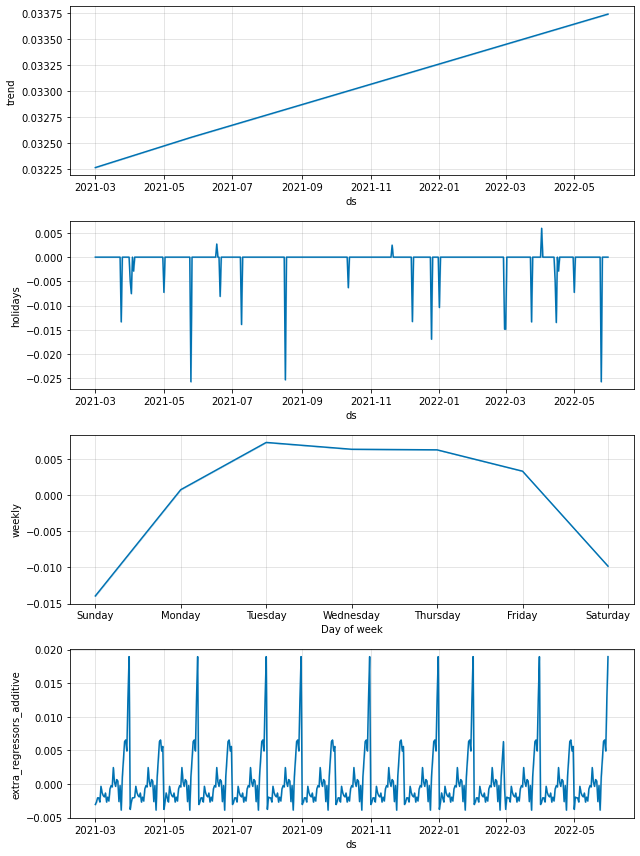

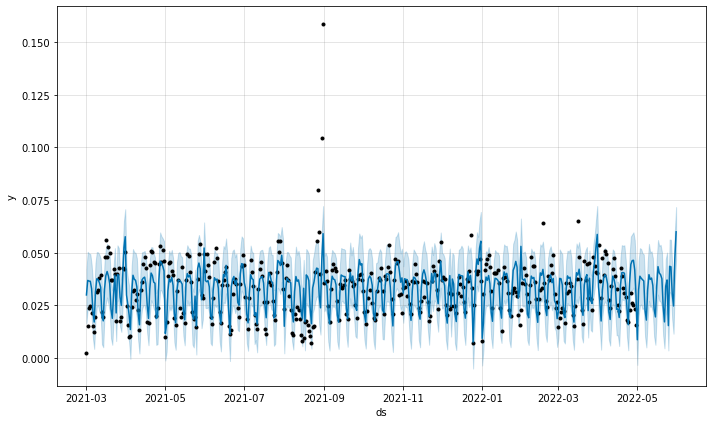

INFO:prophet:Making 11 forecasts with cutoffs between 2021-06-04 00:00:00 and 2022-03-31 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

          ds      yhat  yhat_lower  yhat_upper         y     cutoff
0 2021-06-05  0.016703    0.008742    0.024491  0.019481 2021-06-04
1 2021-06-06  0.017365    0.009759    0.025581  0.016218 2021-06-04
2 2021-06-07  0.033743    0.025301    0.040896  0.028727 2021-06-04
3 2021-06-08  0.037133    0.029231    0.045149  0.045686 2021-06-04
4 2021-06-09  0.035960    0.027735    0.044195  0.052163 2021-06-04
  horizon       mse      rmse      mae      mape     mdape     smape  coverage
0 30 days  0.000165  0.012842  0.00885  0.333214  0.204586  0.277625  0.754545


C:\Users\fernando.garade\anaconda3\envs\mausforecast\lib\site-packages\prophet\plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
C:\Users\fernando.garade\anaconda3\envs\mausforecast\lib\site-packages\prophet\plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


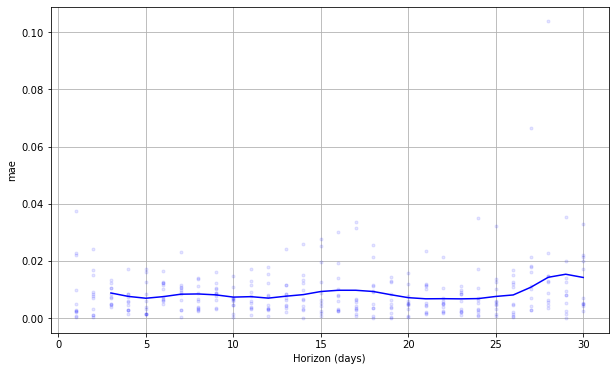

   regressor regressor_mode      coef
30    day_31       additive  0.026109
29    day_30       additive  0.012760
27    day_28       additive  0.006551
26    day_27       additive  0.006309
28    day_29       additive  0.004910
25    day_26       additive  0.003603
16    day_17       additive  0.002450
24    day_25       additive  0.001073
32     fbdom       additive  0.000725
19    day_20       additive  0.000661
20    day_21       additive  0.000445
17    day_18       additive  0.000329
22    day_23       additive -0.000224
14    day_15       additive -0.000238
5      day_6       additive -0.000338
18    day_19       additive -0.000355
15    day_16       additive -0.000433
13    day_14       additive -0.000734
6      day_7       additive -0.001280
9     day_10       additive -0.001338
7      day_8       additive -0.001728
8      day_9       additive -0.001911
11    day_12       additive -0.001953
2      day_3       additive -0.002050
3      day_4       additive -0.002061
12    day_13

In [24]:
forecast_ftus = fit_and_predict(data_ready_ftus, prepare_dataset_for_ftus_model, add_holidays = True, periods=31, yearly_seasonality=False, daily_seasonality=False, weekly_seasonality = True)

In [25]:
total_ftus = make_final_prediction(forecast_ftus, db_fecha_ftu_groupped, day_of_prediction="today")

In [26]:
total_ftus

fecha_1ra_transacion_completed
2022-05-29    14969.123636
dtype: float64

From the plots it can be seen that the data is a bit noisy, but the components of the model seems to make sense:
- The tendence is really flatt. This is true because remember we have percentages each day of month, and those percentages must sum 100% each month, so it can be up and downs but the general tendence should be around the mean (100%/30=3.33%).
- The holidays variable pull down and up the estimations in different dates. This is related with the nature of each holiday. Most of them affect negatively the activity of users, but there are some that motivates it.
- The weekly seasonality is captured correctly penalizing weekends. Remember these are new users, so they may be less tempted to try a new product on a weekend than on a weekday.
- The extra_regressors_additive are the effects of each day number, last day of month and first day of month. They seem to repeat a pattern starting low and growing till the end of each month.

### RUs M1


          ds      yhat  yhat_lower  yhat_upper
0 2021-01-01  0.056619    0.043780    0.069270
1 2021-01-02  0.103152    0.090808    0.115245
2 2021-01-03  0.071164    0.058519    0.083757
3 2021-01-04  0.118213    0.105182    0.131338
4 2021-01-05  0.077839    0.065479    0.089731


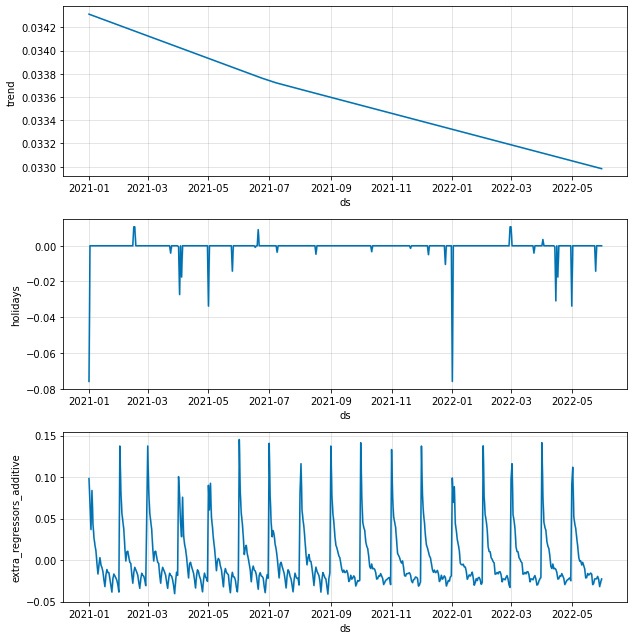

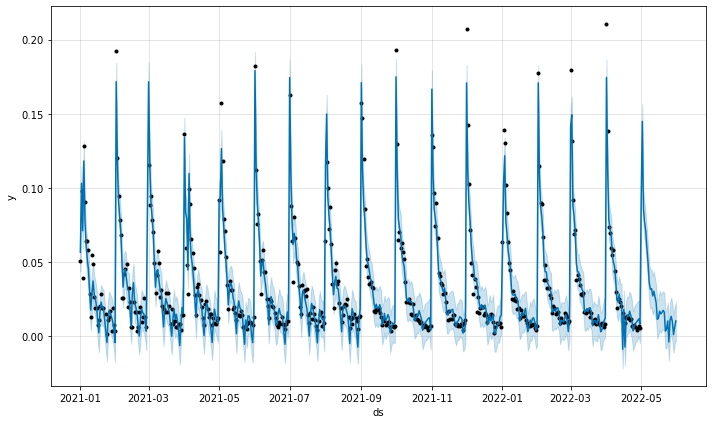

INFO:prophet:Making 13 forecasts with cutoffs between 2021-04-05 00:00:00 and 2022-03-31 00:00:00


  0%|          | 0/13 [00:00<?, ?it/s]

          ds      yhat  yhat_lower  yhat_upper         y     cutoff
0 2021-04-06  0.051832    0.040439    0.062930  0.089324 2021-04-05
1 2021-04-07  0.060016    0.048493    0.071920  0.065836 2021-04-05
2 2021-04-08  0.035349    0.023792    0.047364  0.056228 2021-04-05
3 2021-04-09  0.033285    0.021711    0.045135  0.045907 2021-04-05
4 2021-04-10  0.027376    0.014949    0.039033  0.027758 2021-04-05
  horizon     mse      rmse       mae      mape     mdape    smape  coverage
0 30 days  0.0002  0.014136  0.009053  0.546072  0.258771  0.45592  0.771795


C:\Users\fernando.garade\anaconda3\envs\mausforecast\lib\site-packages\prophet\plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
C:\Users\fernando.garade\anaconda3\envs\mausforecast\lib\site-packages\prophet\plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


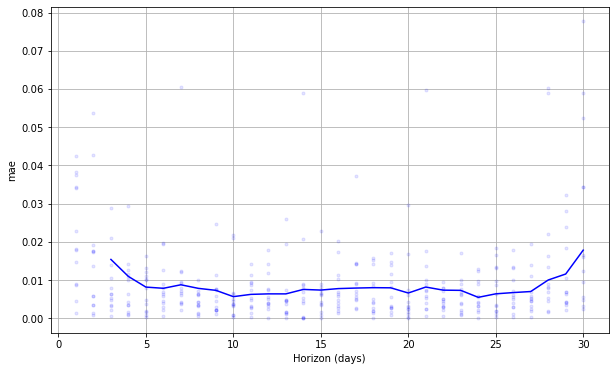

                regressor regressor_mode      coef
0                   day_1       additive  0.097841
1                   day_2       additive  0.076556
2                   day_3       additive  0.052996
3                   day_4       additive  0.044307
46                  fbdom       additive  0.040109
4                   day_5       additive  0.036191
5                   day_6       additive  0.022939
6                   day_7       additive  0.015104
7                   day_8       additive  0.010504
33  weekday_1_before_sept       additive  0.007347
35  weekday_2_before_sept       additive  0.004034
8                   day_9       additive  0.003460
40   weekday_4_since_sept       additive  0.003427
37  weekday_3_before_sept       additive  0.002732
38   weekday_3_since_sept       additive  0.001678
42   weekday_5_since_sept       additive  0.001083
39  weekday_4_before_sept       additive  0.000340
34   weekday_1_since_sept       additive -0.000338
31  weekday_0_before_sept      

In [27]:
forecast_rus_m1 = fit_and_predict(data_ready_RUs_M1, prepare_dataset_for_rus_model, add_holidays = True, periods=31, yearly_seasonality=False, daily_seasonality=False, weekly_seasonality=False)

In [28]:
total_rus_m1 = make_final_prediction(forecast_rus_m1, db_fecha_M1_groupped)

In [29]:
total_rus_m1

first_returning_day_M1
2022-05-29    8217.214214
dtype: float64

### RUs ret

          ds      yhat  yhat_lower  yhat_upper
0 2021-01-01  0.059703    0.047943    0.070762
1 2021-01-02  0.106032    0.094899    0.117086
2 2021-01-03  0.078334    0.067358    0.090115
3 2021-01-04  0.124299    0.112337    0.135804
4 2021-01-05  0.075288    0.063779    0.086593


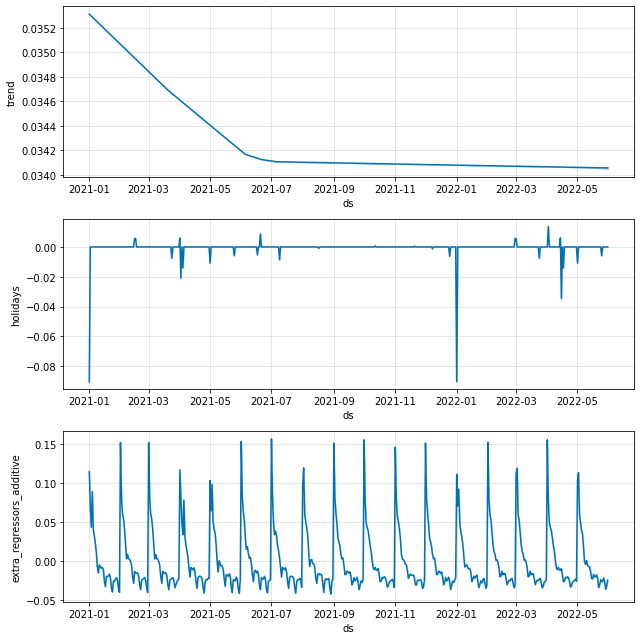

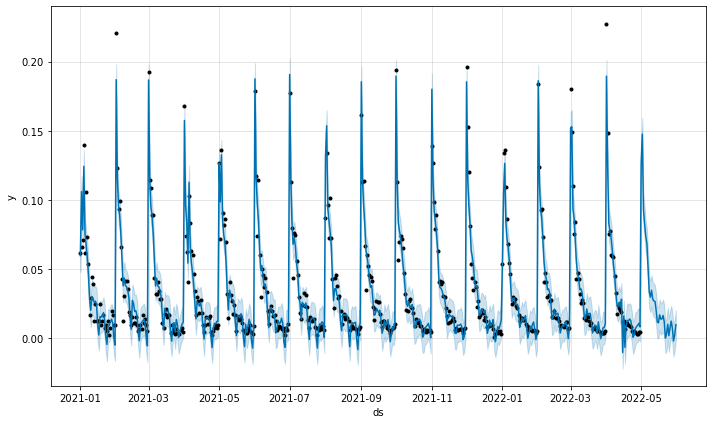

INFO:prophet:Making 13 forecasts with cutoffs between 2021-04-05 00:00:00 and 2022-03-31 00:00:00


  0%|          | 0/13 [00:00<?, ?it/s]

          ds      yhat  yhat_lower  yhat_upper         y     cutoff
0 2021-04-06  0.074717    0.063616    0.085221  0.083398 2021-04-05
1 2021-04-07  0.040566    0.030216    0.051337  0.063320 2021-04-05
2 2021-04-08  0.029090    0.018451    0.038999  0.060232 2021-04-05
3 2021-04-09  0.042072    0.032148    0.052535  0.046332 2021-04-05
4 2021-04-10  0.017977    0.006271    0.027933  0.033977 2021-04-05
  horizon      mse      rmse       mae      mape    mdape     smape  coverage
0 30 days  0.00013  0.011383  0.007625  0.559158  0.26728  0.485159  0.797436


C:\Users\fernando.garade\anaconda3\envs\mausforecast\lib\site-packages\prophet\plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
C:\Users\fernando.garade\anaconda3\envs\mausforecast\lib\site-packages\prophet\plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


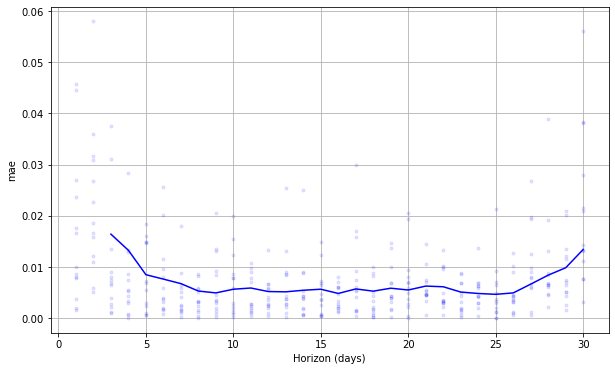

                regressor regressor_mode      coef
0                   day_1       additive  0.112176
1                   day_2       additive  0.079743
2                   day_3       additive  0.058514
3                   day_4       additive  0.049328
46                  fbdom       additive  0.039694
4                   day_5       additive  0.038560
5                   day_6       additive  0.030698
6                   day_7       additive  0.018381
7                   day_8       additive  0.008528
37  weekday_3_before_sept       additive  0.004613
40   weekday_4_since_sept       additive  0.003504
39  weekday_4_before_sept       additive  0.002539
35  weekday_2_before_sept       additive  0.001789
8                   day_9       additive  0.001647
33  weekday_1_before_sept       additive  0.001449
38   weekday_3_since_sept       additive  0.001153
45                   ldom       additive  0.000980
9                  day_10       additive  0.000390
34   weekday_1_since_sept      

In [30]:
forecast_rus_ret = fit_and_predict(data_ready_RUs_ret, prepare_dataset_for_rus_model, add_holidays = True, periods=31, yearly_seasonality=False, daily_seasonality=False, weekly_seasonality=False)
total_rus_ret = make_final_prediction(forecast_rus_ret, db_fecha_rusret_groupped)

In [31]:
total_rus_ret

first_returning_day_M2
2022-05-29    61305.890871
dtype: float64

### ZRs

          ds      yhat  yhat_lower  yhat_upper
0 2021-01-01  0.016233   -0.009010    0.044892
1 2021-01-02  0.044740    0.018281    0.072816
2 2021-01-04  0.082507    0.056650    0.108804
3 2021-01-05  0.056937    0.030629    0.082270
4 2021-01-06  0.050840    0.023405    0.076813


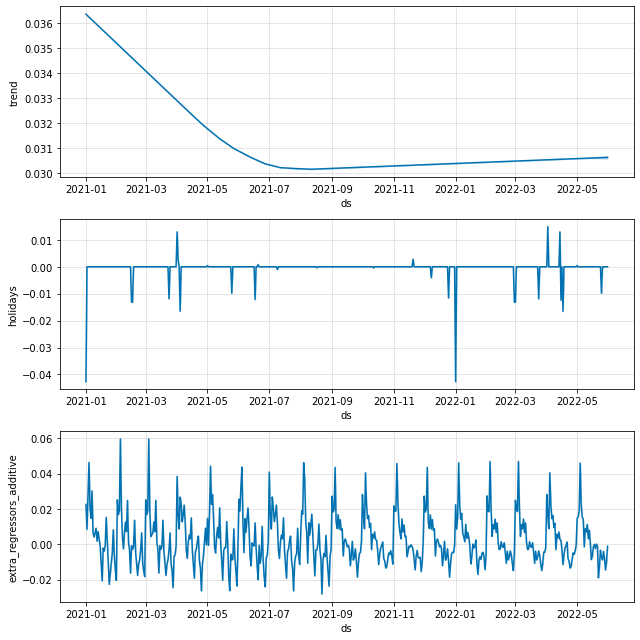

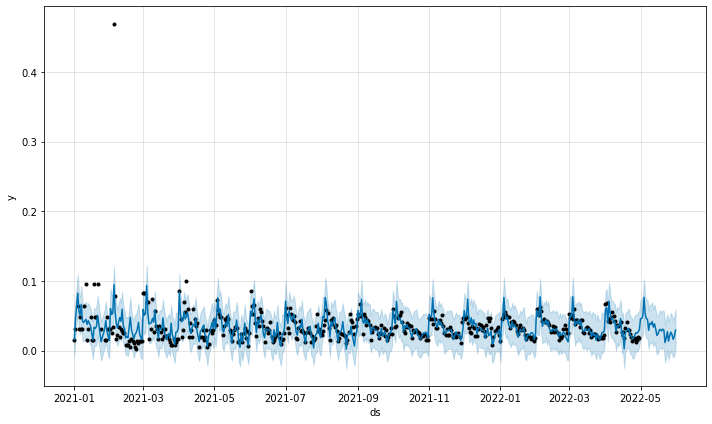

INFO:prophet:Making 13 forecasts with cutoffs between 2021-04-05 00:00:00 and 2022-03-31 00:00:00


  0%|          | 0/13 [00:00<?, ?it/s]

          ds      yhat  yhat_lower  yhat_upper         y     cutoff
0 2021-04-06  0.023366   -0.023893    0.069550  0.055276 2021-04-05
1 2021-04-07 -0.003178   -0.048032    0.042694  0.100503 2021-04-05
2 2021-04-08  0.026392   -0.021427    0.071771  0.060302 2021-04-05
3 2021-04-09  0.073395    0.026387    0.118595  0.020101 2021-04-05
4 2021-04-10  0.008292   -0.039434    0.053455  0.040201 2021-04-05
  horizon       mse      rmse       mae      mape     mdape    smape  coverage
0 30 days  0.000403  0.020084  0.012404  0.421301  0.240034  0.42661  0.945876


C:\Users\fernando.garade\anaconda3\envs\mausforecast\lib\site-packages\prophet\plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
C:\Users\fernando.garade\anaconda3\envs\mausforecast\lib\site-packages\prophet\plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


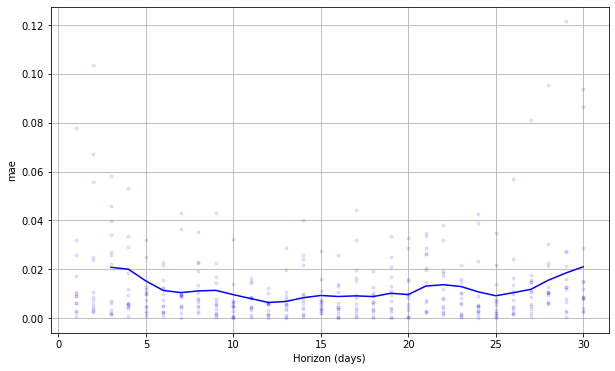

                regressor regressor_mode      coef
3                   day_4       additive  0.041709
0                   day_1       additive  0.020563
4                   day_5       additive  0.018250
37  weekday_3_before_sept       additive  0.017859
2                   day_3       additive  0.014578
1                   day_2       additive  0.014360
6                   day_7       additive  0.012371
5                   day_6       additive  0.010256
8                   day_9       additive  0.010062
10                 day_11       additive  0.006992
45                   ldom       additive  0.006290
40   weekday_4_since_sept       additive  0.005134
35  weekday_2_before_sept       additive  0.004432
34   weekday_1_since_sept       additive  0.004358
7                   day_8       additive  0.004346
36   weekday_2_since_sept       additive  0.004246
38   weekday_3_since_sept       additive  0.003950
12                 day_13       additive  0.002778
9                  day_10      

In [32]:
forecast_zrs = fit_and_predict(data_ready_ZRs, prepare_dataset_for_rus_model, add_holidays = True, periods=31, yearly_seasonality=False, daily_seasonality=False, weekly_seasonality=False)
total_zrs = make_final_prediction(forecast_zrs, db_fecha_zrs_groupped)

In [33]:
total_zrs

first_returning_day_M2
2022-05-29    7801.02841
dtype: float64

For these other type of users the conclusions are almost the same as the drawn for the FTUs. One thing that is worth mentioning for these users is that the weekly seasonality was not modeled as in FTUs but introduced as an extra_regressor. This is because we detected that the weekly seasonality for these users changed dramatically since september. Therefore, it was necessary to add regressors for the days of the week before september and others for the ones since september.

In [34]:
total_maus = total_ftus + total_rus_m1 + total_rus_ret + total_zrs
total_maus

fecha_1ra_transacion_completed
2022-05-29    92293.25713
dtype: float64

In [35]:
print(f'FTUs: {total_ftus.values}')
print(f'RUs M1: {total_rus_m1.values}')
print(f'RUs ret: {total_rus_ret.values}')
print(f'ZRs: {total_zrs.values}')
print(f'MAUs: {total_maus.values}')

FTUs: [14969.1236356]
RUs M1: [8217.2142139]
RUs ret: [61305.89087056]
ZRs: [7801.02841004]
MAUs: [92293.2571301]


As shown above the MAUs were calculated as a simple sum of the forecast of each active users segment.